<a href="https://colab.research.google.com/github/MuhammadHelmyOmar/Hadith/blob/main/bow_featuring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Next

- Preprocessing
  - Remove prefix as "قال رسول الله" (will find it in the prophet said so)
  - Remove max_df in count_vectorizer
- Visualize
  - try word cloud for each class


# Loading Data

In [2]:
import pandas as pd

In [25]:
data_url = 'https://raw.githubusercontent.com/KamelGaanoun/MHDetection/main/Corpus/trainFinal.csv'

data = pd.read_csv(data_url, index_col='Unnamed: 0')
print("CSV file loaded successfully!")
# Display the first few rows of the DataFrame
data.head()

CSV file loaded successfully!


,Matan,Degree
19036,لقد رأيتني وأنا ثلث الإسلام،‏.‏,0
17209,هريرة، أن أعرابيا، أتى النبي صلى الله عليه وس...,0
11245,عائشة، قالت كنت أفتل قلائد هدى رسول الله صلى ...,0
2827,قال النبي صلى الله عليه وسلم ‏ ‏ إني فرطكم على...,0
23616,عن النبي صلى الله عليه وسلم قال أقيموا الركوع ...,0


In [26]:
print(len(data))
print(data['Degree'].value_counts())

21248
Degree
0    19286
1     1962
Name: count, dtype: int64


In [27]:
# Filter data for each degree
data_degree_0 = data[data['Degree'] == 0]
data_degree_1 = data[data['Degree'] == 1]

# Sample 200 rows from each degree (if available)
# Use .sample(n, random_state) for reproducible sampling
sampled_degree_0 = data_degree_0.sample(n=min(1962, len(data_degree_0)), random_state=42)
sampled_degree_1 = data_degree_1.sample(n=min(1962, len(data_degree_1)), random_state=42)

# Concatenate the sampled dataframes
sampled_data = pd.concat([sampled_degree_0, sampled_degree_1])

# Display the value counts to verify the sampling
print("Value counts of the sampled data:")
display(sampled_data['Degree'].value_counts())

# Display the head of the sampled data
print("\nSampled data head:")
display(sampled_data.head())

Value counts of the sampled data:


,count
Degree,
0,1962
1,1962



Sampled data head:


,Matan,Degree
13645,أنها استعارت من أسماء قلادة فهلكت فأرسل النبي ...,0
16561,يقول كان رسول الله صلى الله عليه وسلم يأتي قبا...,0
13787,هريرة، أن رسول الله صلى الله عليه وسلم قال قلب...,0
4475,أبيه، أن النبي صلى الله عليه وسلم قال لا تزال ...,0
16463,القاسم صلى الله عليه وسلم تسموا باسمي ولا تكنو...,0


In [28]:
labels = sampled_data['Degree'].values
labels.shape

(3924,)

# Preprocessing

In [29]:
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def remove_diacritics(text):
  # remove diacritics
  text = text.replace(u"\u064B", "")  # fatHatayn
  text = text.replace(u"\u064C", "")  # Dammatayn
  text = text.replace(u"\u064D", "")  # kasratayn
  text = text.replace(u"\u064E", "")  # fatHa
  text = text.replace(u"\u064F", "")  # Damma
  text = text.replace(u"\u0650", "")  # kasra
  text = text.replace(u"\u0651", "")  # shaddah
  text = text.replace(u"\u0652", "")  # sukuun
  text = text.replace(u"\u0670", "`")  # dagger 'alif
  return text

In [31]:
sampled_data['Matan'] = sampled_data['Matan'].apply(lambda hadith: remove_diacritics(hadith))

In [32]:
sampled_data['text_length'] = sampled_data['Matan'].str.len()
sampled_data['stopwords_count'] = sampled_data['Matan'].apply(lambda hadith: len([word for word in hadith.split() if word in arabic_stopwords]))
sampled_data = sampled_data.sort_values(by='text_length',ascending=[0])
sampled_data.head()

,Matan,Degree,text_length,stopwords_count
1427,لما أسري بي إلى السماء رأيت فيها أعاجيب من ع...,1,29527,1629
4106,أن جبريل عليه السلام أتى النبي صلى الله عليه...,1,9507,440
3738,زيارة إبليس اللعين للنبي صلى الله عليه وسلم...,1,9363,474
10718,أنس بن مالك رضي الله عنه قال: ((جاء جبريل إ...,1,8711,438
22047,((روي عن النبي صلى الله عليه وآله وسلم أنه ق...,1,7504,471


In [33]:
def remove_keyrings(text):
    # This regex pattern matches various keyrings like "قال رسول الله صلى الله عليه وسلم" and variations
    pattern = r'قال\s*رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم|قال\s*صلى\s*الله\s*عليه\s*وسلم|صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*قال|صلى\s*الله\s*عليه\s*وسلم\s*قال|وفي\s*الحديث|قال\s*رسول\s*الله\s*ص|صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*يقول|صلى\s*الله\s*عليه\s*وسلم\s*يقول|قال\s*رسول\s*الله|قال\s*النبي\s*صلى\s*الله\s*عليه\s*وسلم|النبي\s*صلى\s*الله\s*عليه\s*وسلم\s*قال|قال\s*النبي|عن\s*رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*قال|عن\s*رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم\s*قال|عن\s*النبي\s*صلى\s*الله\s*عليه\s*وسلم\s*أنه\s*قال|عن\s*النبي\s*صلى\s*الله\s*عليه\s*وسلم\s*قال|رسول\s*الله\s*صلى\s*الله\s*عليه\s*وسلم\s*قال'
    text = re.sub(pattern, '', text)
    return text

sampled_data['Matan'] = sampled_data['Matan'].apply(remove_keyrings)

print("Keyrings removed from 'Matan' column.")
display(sampled_data.head())

Keyrings removed from 'Matan' column.


,Matan,Degree,text_length,stopwords_count
1427,لما أسري بي إلى السماء رأيت فيها أعاجيب من ع...,1,29527,1629
4106,أن جبريل عليه السلام أتى النبي صلى الله عليه...,1,9507,440
3738,زيارة إبليس اللعين للنبي صلى الله عليه وسلم...,1,9363,474
10718,أنس بن مالك رضي الله عنه قال: ((جاء جبريل إ...,1,8711,438
22047,((روي عن النبي صلى الله عليه وآله وسلم أنه ق...,1,7504,471


In [11]:
# # Create a CountVectorizer Object
# vectorizer = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1)

# # Fit and transform the corpus
# bow = vectorizer.fit_transform(sampled_data['Matan'])

# # Print the length of the generated vocabulary
# print("Vocabulary Size:", len(vectorizer.get_feature_names_out()))

# # Print the Bag-of-Words matrix
# print("BoW Representation:")
# print(bow.toarray())
# print(bow.shape)

# Exploratory Text Analysis

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

## Top N words

In [12]:
# # Get feature names (words)
# words = vectorizer.get_feature_names_out()

# # Sum up the occurrences of each word across all documents
# counts = bow.sum(axis=0).A1

# # Create a dictionary of word counts
# word_counts = dict(zip(words, counts))

# # Sort the dictionary by frequency in descending order
# word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

In [ ]:
# # Get the list of top N words from the previous analysis
# top_n = 20
# print(f"Top {top_n} most frequent words:")
# top_words = list(word_counts.keys())[:top_n]

# # Filter data by degree
# data_degree_0 = sampled_data[sampled_data['Degree'] == 0]['Matan']
# data_degree_1 = sampled_data[sampled_data['Degree'] == 1]['Matan']

# # Create CountVectorizer objects for each degree, using the vocabulary of the top words
# vectorizer_degree_0 = CountVectorizer(vocabulary=top_words)
# vectorizer_degree_1 = CountVectorizer(vocabulary=top_words)

# # Transform the data for each degree
# bow_degree_0 = vectorizer_degree_0.fit_transform(data_degree_0)
# bow_degree_1 = vectorizer_degree_1.fit_transform(data_degree_1)

# # Sum the occurrences of each top word in each degree
# word_counts_degree_0 = bow_degree_0.sum(axis=0).A1
# word_counts_degree_1 = bow_degree_1.sum(axis=0).A1

# # Create dictionaries of word counts for each degree
# word_counts_0_dict = dict(zip(top_words, word_counts_degree_0))
# word_counts_1_dict = dict(zip(top_words, word_counts_degree_1))

# # Create a DataFrame to compare the counts
# comparison_df = pd.DataFrame({
#     'Degree_0_Count': word_counts_0_dict,
#     'Degree_1_Count': word_counts_1_dict
# })

# # Calculate the total count for each word across both degrees
# comparison_df['Total Count'] = comparison_df['Degree_0_Count'] + comparison_df['Degree_1_Count']

# # Display the comparison table, sorted by total count
# display(comparison_df.sort_values(by='Total Count', ascending=False))

In [35]:
top_n = 20

# Filter data by degree
data_degree_0_text = sampled_data[sampled_data['Degree'] == 0]['Matan']
data_degree_1_text = sampled_data[sampled_data['Degree'] == 1]['Matan']

# Create CountVectorizer objects for each degree
vectorizer_degree_0 = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1)
vectorizer_degree_1 = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1)

# Transform the data for each degree
bow_degree_0 = vectorizer_degree_0.fit_transform(data_degree_0_text)
bow_degree_1 = vectorizer_degree_1.fit_transform(data_degree_1_text)

# Get feature names (words) and counts for each degree
words_degree_0 = vectorizer_degree_0.get_feature_names_out()
counts_degree_0 = bow_degree_0.sum(axis=0).A1
word_counts_0 = dict(zip(words_degree_0, counts_degree_0))
word_counts_0 = dict(sorted(word_counts_0.items(), key=lambda item: item[1], reverse=True))

words_degree_1 = vectorizer_degree_1.get_feature_names_out()
counts_degree_1 = bow_degree_1.sum(axis=0).A1
word_counts_1 = dict(zip(words_degree_1, counts_degree_1))
word_counts_1 = dict(sorted(word_counts_1.items(), key=lambda item: item[1], reverse=True))


print(f"Top {top_n} most frequent words for Degree 0:")
display(pd.DataFrame(list(word_counts_0.items())[:top_n], columns=['Word', 'Count']))

print(f"\nTop {top_n} most frequent words for Degree 1:")
display(pd.DataFrame(list(word_counts_1.items())[:top_n], columns=['Word', 'Count']))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Top 20 most frequent words for Degree 0:


,Word,Count
0,الله,4124
1,صلى,1858
2,وسلم,1781
3,قال,1754
4,رسول,1331
5,فقال,851
6,النبي,689
7,بن,562
8,ابن,246
9,أبي,239



Top 20 most frequent words for Degree 1:


,Word,Count
0,الله,2845
1,قال,775
2,صلى,577
3,فقال,525
4,وسلم,516
5,رسول,435
6,يوم,362
7,الجنة,337
8,علي,277
9,محمد,256


## Comparing lengths

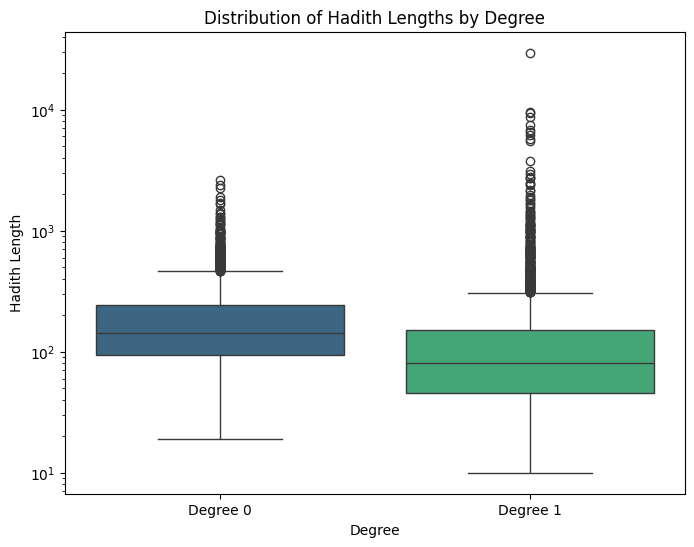

In [21]:
# Create box plots for Hadith lengths by degree
plt.figure(figsize=(8, 6))
sns.boxplot(x='Degree', y='text_length', data=sampled_data, hue='Degree', palette='viridis', legend=False)
plt.title('Distribution of Hadith Lengths by Degree')
plt.xlabel('Degree')
plt.ylabel('Hadith Length')
plt.xticks([0, 1], ['Degree 0', 'Degree 1'])
plt.yscale('log') # Scaled the y-axis logarithmically
plt.show()

In [22]:
# Calculate percentiles for text length by degree
percentiles = sampled_data.groupby('Degree')['text_length'].quantile([0.25, 0.5, 0.75])

print("Percentiles of Hadith Length by Degree:")
display(percentiles)

Percentiles of Hadith Length by Degree:


Degree      
0       0.25     94.00
        0.50    144.00
        0.75    241.75
1       0.25     46.00
        0.50     80.00
        0.75    151.00
Name: text_length, dtype: float64

In [24]:
# Calculate IQR for each degree
Q1 = sampled_data.groupby('Degree')['text_length'].quantile(0.25)
Q3 = sampled_data.groupby('Degree')['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
upper_bound = Q3 + 1.5 * IQR

print("\nUpper bounds for outliers:")
display(upper_bound)

# Identify outliers for each degree
outliers_degree_0 = sampled_data[(sampled_data['Degree'] == 0) &
                                (sampled_data['text_length'] > upper_bound[0])]

outliers_degree_1 = sampled_data[(sampled_data['Degree'] == 1) &
                                (sampled_data['text_length'] > upper_bound[1])]


# Print the number of outliers
print(f"Number of outliers for Degree 0 above upper bound: {len(outliers_degree_0)}")
print(f"Number of outliers for Degree 1 above upper bound: {len(outliers_degree_1)}")


Upper bounds for outliers:


,text_length
Degree,
0,463.375
1,308.500


Number of outliers for Degree 0 above upper bound: 146
Number of outliers for Degree 1 above upper bound: 227


# Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow, labels, test_size=0.2,random_state=109)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3139, 960), (785, 960), (3139,), (785,))

# SVM Classifier

## Modeling

In [ ]:
from sklearn.svm import LinearSVC
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
clf = LinearSVC(random_state=109)
clf.fit(X_train, y_train)

LinearSVC(random_state=109)

## Evaluation

In [ ]:
from sklearn import metrics

In [ ]:
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8369426751592357
Precision: 0.8067632850241546
Recall: 0.8743455497382199
F1 Score: 0.8391959798994975


In [ ]:
coefficients = list(clf.coef_[0])
words = list(vectorizer.get_feature_names_out())
maximas = {}
minimas = {}

for i in range(100):
  max_value = max(coefficients)
  min_value = min(coefficients)

  mx = coefficients.index(max_value)
  maximas[words[mx]] = max_value
  coefficients.pop(mx)
  words.pop(mx)

  mn = coefficients.index(min_value)
  minimas[words[mn]] = min_value
  coefficients.pop(mn)

In [ ]:
minimas.keys()

dict_keys(['الرابعة', 'فأمره', 'يأكل', 'أشهد', 'فيهم', 'عبد', 'الأمة', 'عثمان', 'الأسود', 'فرأى', 'روح', 'فجاء', 'هريرة', 'الأرض', 'المرأة', 'أحدهم', 'فصلى', 'وآله', 'لمن', 'بيني', 'يرد', 'العبد', 'جارية', 'الحج', 'جالس', 'عهد', 'فليس', 'خرجت', 'العلي', 'شئت', 'حمراء', 'كلمة', 'ونحن', 'الدنيا', 'فقد', 'قيس', 'الإيمان', 'موسى', 'الجبال', 'مر', 'أكبر', 'كتابه', 'فهل', 'المريض', 'صليت', 'وساق', 'اليهود', 'وذلك', 'الولد', 'فإني', 'المسلمين', 'مثله', 'ذنب', 'يخرج', 'تكون', 'جالسا', 'الإمام', 'واليوم', 'فذلك', 'وإني', 'أمي', 'العمل', 'نزلت', 'خطب', 'لأن', 'فيقول', 'الزبير', 'مدينة', 'معاوية', 'قلب', 'أمتك', 'ذهبت', 'الكعبة', 'واحدة', 'للنبي', 'حديثا', 'كانت', 'كلها', 'الليل', 'فذكرت', 'كأنه', 'عباس', 'سائر', 'فجعل', 'الزمان', 'مالي', 'روي', 'حديث', 'فأنا', 'أخاه', 'زاد', 'شيئا', 'الفقر', 'أشد', 'مرات'])

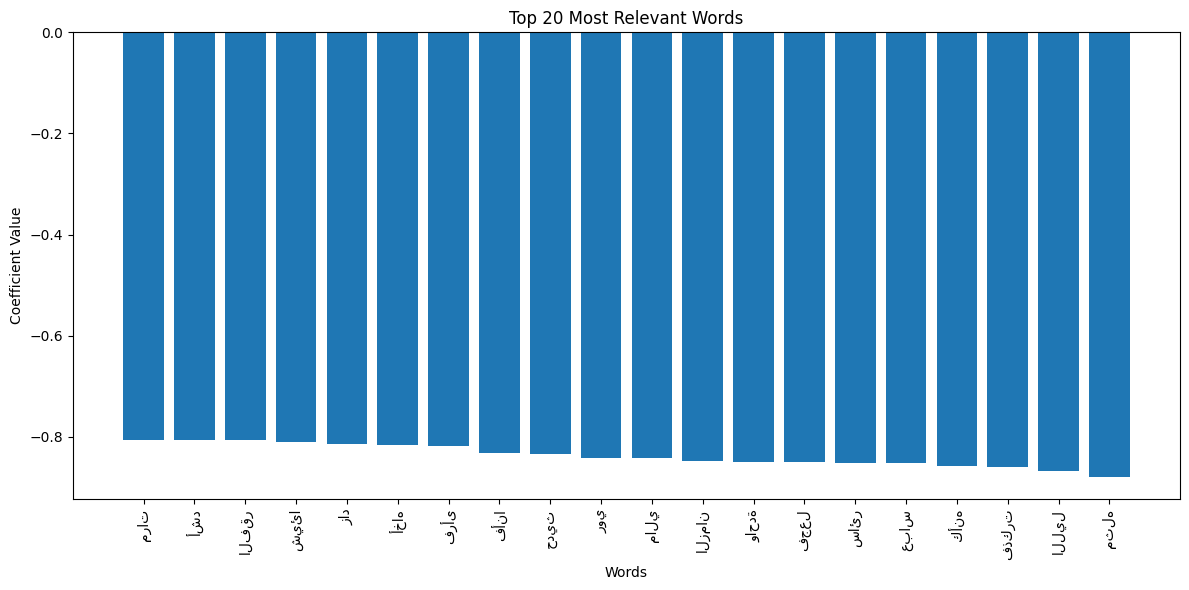

In [ ]:
# Plot the coefficients for minimas
minimas = dict(sorted(minimas.items(), key=lambda item: abs(item[1]), reverse=False))

plt.figure(figsize=(12, 6))
plt.bar(list(minimas.keys())[:20], list(minimas.values())[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Relevant Words')
plt.xlabel('Words')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [ ]:
maximas.keys()

dict_keys(['ينادي', 'فوضع', 'ينقص', 'قدير', 'طعام', 'نام', 'نحوه', 'يقول', 'يشرب', 'مسجد', 'فأخذ', 'وابن', 'يذكر', 'فأتاه', 'وقالت', 'فتوضأ', 'أعظم', 'تصلي', 'يخطب', 'بمثل', 'الصديق', 'يحدث', 'فقال', 'داود', 'بكل', 'أردت', 'آل', 'الصراط', 'صاحب', 'نظر', 'خاتم', 'لأبي', 'بالبيت', 'جلس', 'أعطي', 'نفر', 'وليس', 'مسلم', 'جاء', 'فقالوا', 'حذيفة', 'وجهي', 'فهو', 'رأسك', 'ربه', 'نفسي', 'نبيا', 'فأقبل', 'غفر', 'السابعة', 'مسيرة', 'الولد', 'النظر', 'مني', 'فضل', 'يبعث', 'الأنصاري', 'وأمر', 'ليلا', 'صوم', 'وساق', 'جابر', 'الإيمان', 'بسم', 'غزوة', 'الحكم', 'كلوا', 'الدعاء', 'الطيب', 'هشام', 'فتح', 'بينا', 'اليوم', 'حرام', 'سنة', 'العباس', 'فمر', 'درجة', 'فيقول', 'ليلة', 'العمل', 'الثانية', 'هريرة', 'الكتاب', 'إليهم', 'شفاء', 'الخير', 'انصرف', 'زيد', 'أرحم', 'مالي', 'جالسا', 'وإنه', 'دعاء', 'ابن', 'وجلالي', 'إسرائيل', 'النار', 'إنك', 'الليلة'])

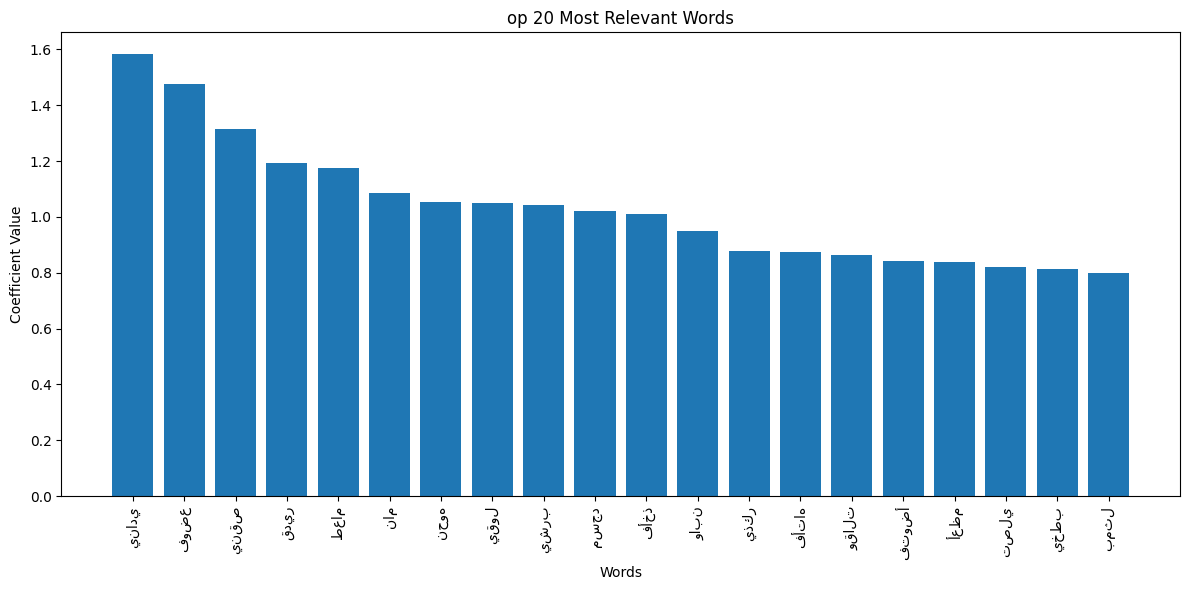

In [ ]:
# Plot the coefficients for maximas
maximas = dict(sorted(maximas.items(), key=lambda item: abs(item[1]), reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(list(maximas.keys())[:20], list(maximas.values())[:20])
plt.xticks(rotation=90)
plt.title('op 20 Most Relevant Words')
plt.xlabel('Words')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Lasso Regression Model

In [ ]:
from sklearn.linear_model import Lasso


Fitting Lasso model with alpha = 0.01


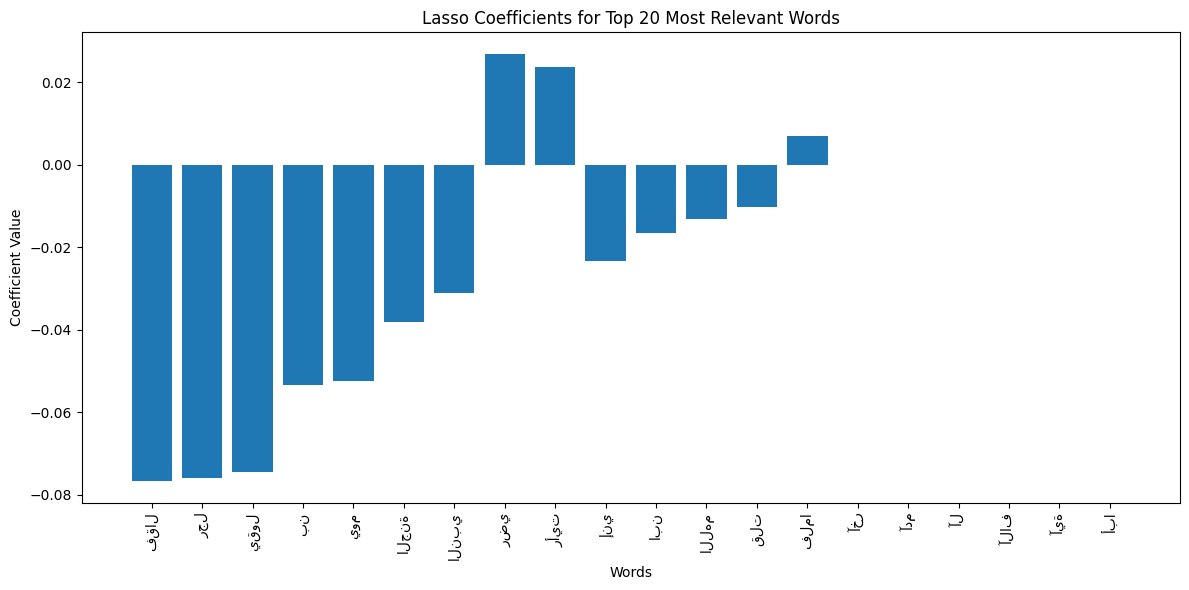


Fitting Lasso model with alpha = 0.005


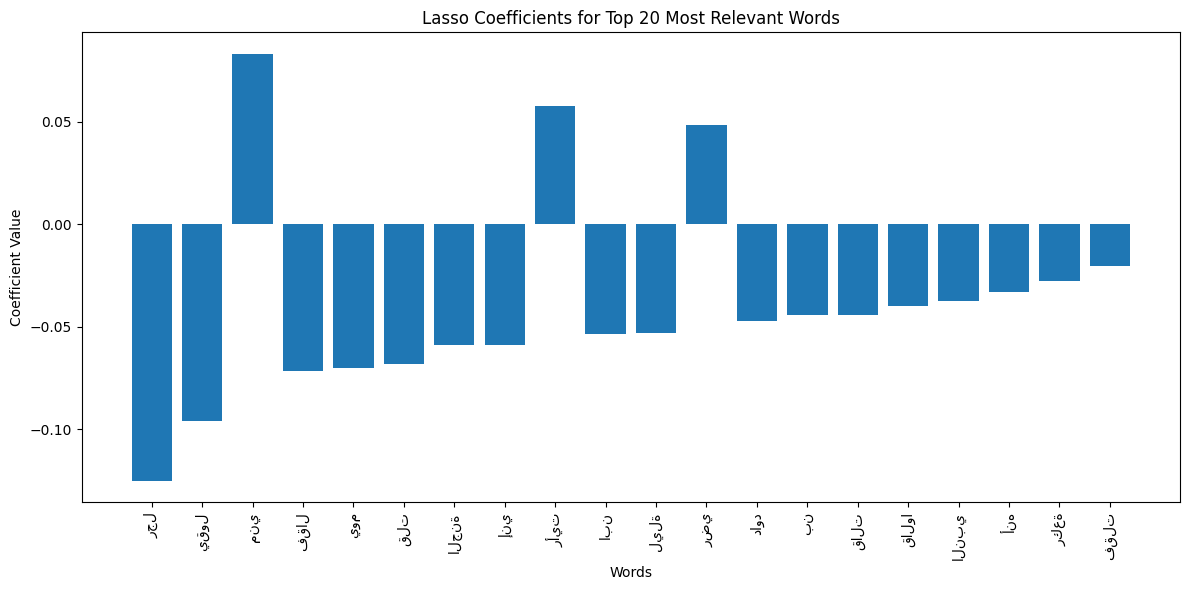


Fitting Lasso model with alpha = 0.001


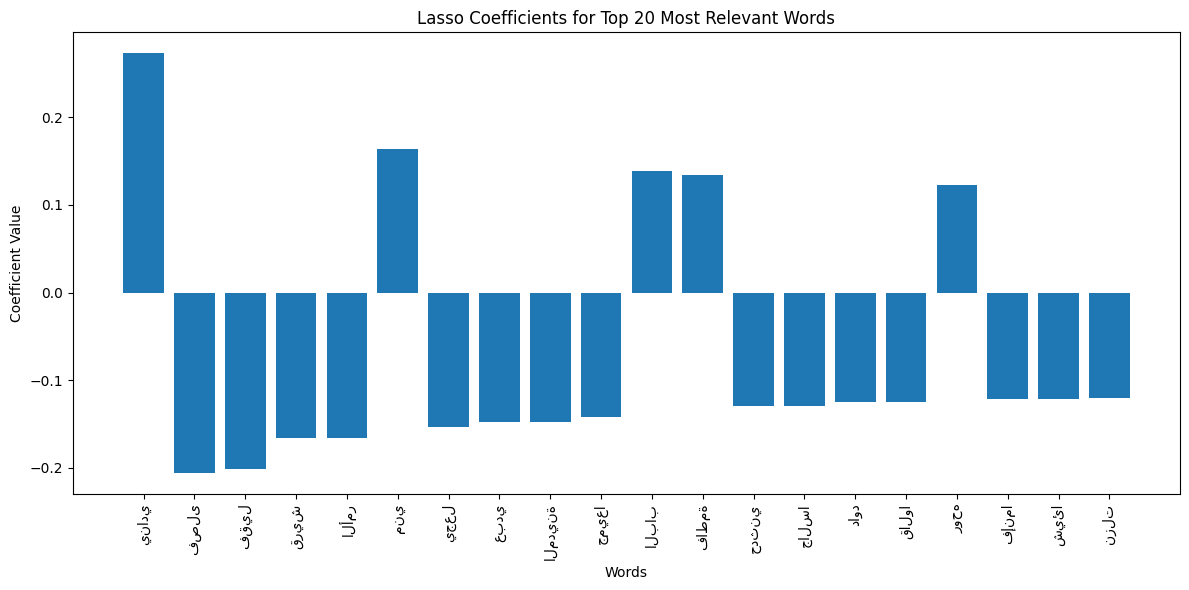

In [ ]:
# Try different alpha values and observe the coefficients
alpha_values = [0.01, 0.005, 0.001]
words = vectorizer.get_feature_names_out()

for alpha in alpha_values:
    print(f"\nFitting Lasso model with alpha = {alpha}")
    lasso_model = Lasso(alpha=alpha, random_state=109)
    lasso_model.fit(X_train, y_train)
    lasso_coefficients = lasso_model.coef_
    word_coefficients = dict(zip(words, lasso_coefficients))
    word_coefficients = dict(sorted(word_coefficients.items(), key=lambda item: abs(item[1]), reverse=True))

    # Plot the coefficients
    plt.figure(figsize=(12, 6))
    plt.bar(list(word_coefficients.keys())[:20], list(word_coefficients.values())[:20])
    plt.xticks(rotation=90)
    plt.title('Lasso Coefficients for Top 20 Most Relevant Words')
    plt.xlabel('Words')
    plt.ylabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

## Evaluation

In [ ]:
y_pred_lasso = (lasso_model.predict(X_test) > 0.5).astype(int)

# Evaluate the performance of the Lasso model as a classifier
accuracy = metrics.accuracy_score(y_test, y_pred_lasso)
precision = metrics.precision_score(y_test, y_pred_lasso)
recall = metrics.recall_score(y_test, y_pred_lasso)
f1 = metrics.f1_score(y_test, y_pred_lasso)

print(f"Lasso Model Performance (as a classifier) with alpha={lasso_model.alpha}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Lasso Model Performance (as a classifier) with alpha=0.001:
Accuracy: 0.7299
Precision: 0.6562
Recall: 0.9346
F1 Score: 0.7711


# NB Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

## Modeling

In [ ]:
# Train a Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

## Evaluation

In [ ]:
# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the performance of the Naive Bayes model
accuracy_nb = metrics.accuracy_score(y_test, y_pred_nb)
precision_nb = metrics.precision_score(y_test, y_pred_nb)
recall_nb = metrics.recall_score(y_test, y_pred_nb)
f1_nb = metrics.f1_score(y_test, y_pred_nb)

print("Naive Bayes Model Performance:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")

Naive Bayes Model Performance:
Accuracy: 0.7465
Precision: 0.7440
Recall: 0.7304
F1 Score: 0.7371


# Gemi